In [1]:
import os
import shutil

In [2]:
kaggle_json_path = '/content/drive/MyDrive/EAI6010_Final Project/fake_image_detector_project/kaggle.json'

In [3]:
# Create .kaggle directory and copy credentials
!mkdir -p ~/.kaggle
shutil.copy(kaggle_json_path, '/root/.kaggle/kaggle.json')
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!pip install -q torch torchvision matplotlib seaborn scikit-learn pillow numpy pandas

In [5]:
# Download CIFAKE Dataset
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images
!unzip -q cifake-real-and-ai-generated-synthetic-images.zip

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
 95% 99.0M/105M [00:00<00:00, 510MB/s]
100% 105M/105M [00:00<00:00, 492MB/s] 


In [6]:
#Explore Dataset Structure
print("\n" + "="*50)
print("DATASET STRUCTURE")
print("="*50)

# Check directory structure
import os

if os.path.exists('train'):
    print("\n📁 Train folder found")
    train_path = 'train'
    real_path = os.path.join(train_path, 'REAL')
    fake_path = os.path.join(train_path, 'FAKE')

    real_count = len(os.listdir(real_path)) if os.path.exists(real_path) else 0
    fake_count = len(os.listdir(fake_path)) if os.path.exists(fake_path) else 0

    print(f"   ├── REAL images: {real_count:,}")
    print(f"   └── FAKE (AI-generated) images: {fake_count:,}")
    print(f"\nTotal images: {real_count + fake_count:,}")
    print(f"Dataset balance: {real_count/(real_count+fake_count)*100:.1f}% REAL, {fake_count/(real_count+fake_count)*100:.1f}% FAKE")

if os.path.exists('test'):
    print("\n📁 Test folder found")
    test_path = 'test'
    test_real_path = os.path.join(test_path, 'REAL')
    test_fake_path = os.path.join(test_path, 'FAKE')

    test_real_count = len(os.listdir(test_real_path)) if os.path.exists(test_real_path) else 0
    test_fake_count = len(os.listdir(test_fake_path)) if os.path.exists(test_fake_path) else 0

    print(f"   ├── REAL images: {test_real_count:,}")
    print(f"   └── FAKE (AI-generated) images: {test_fake_count:,}")


DATASET STRUCTURE

📁 Train folder found
   ├── REAL images: 50,000
   └── FAKE (AI-generated) images: 50,000

Total images: 100,000
Dataset balance: 50.0% REAL, 50.0% FAKE

📁 Test folder found
   ├── REAL images: 10,000
   └── FAKE (AI-generated) images: 10,000



VISUALIZING SAMPLE IMAGES


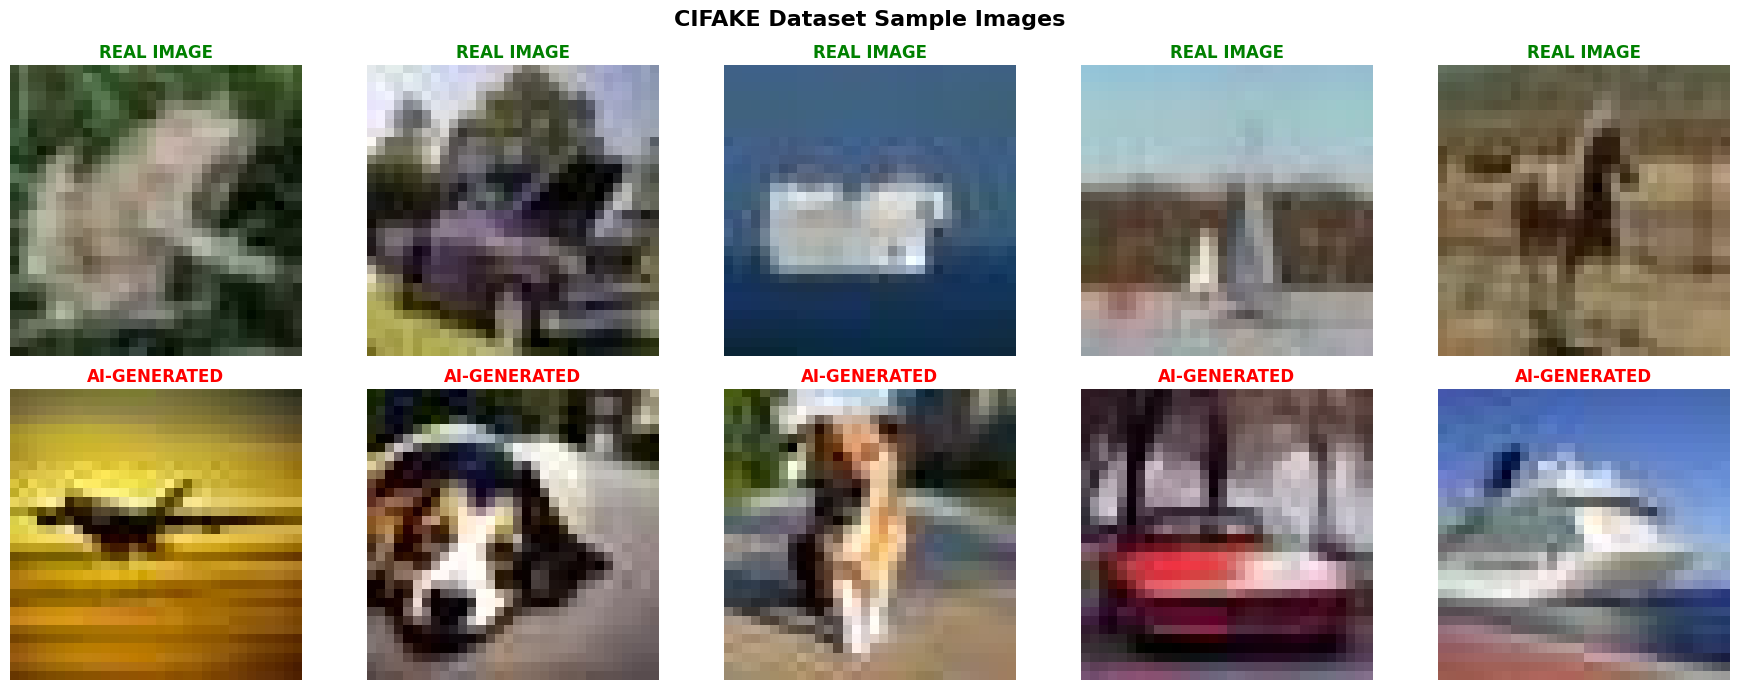

In [7]:
# Visualize Sample Images
print("\n" + "="*50)
print("VISUALIZING SAMPLE IMAGES")
print("="*50)

import matplotlib.pyplot as plt
from PIL import Image
import random

# Get random samples
real_images = [os.path.join(real_path, img) for img in os.listdir(real_path)]
fake_images = [os.path.join(fake_path, img) for img in os.listdir(fake_path)]

real_samples = random.sample(real_images, 5)
fake_samples = random.sample(fake_images, 5)

# Create visualization
fig, axes = plt.subplots(2, 5, figsize=(18, 7))

for i in range(5):
    # Real images
    real_img = Image.open(real_samples[i])
    axes[0, i].imshow(real_img)
    axes[0, i].set_title('REAL IMAGE', fontsize=12, fontweight='bold', color='green')
    axes[0, i].axis('off')

    # Fake images
    fake_img = Image.open(fake_samples[i])
    axes[1, i].imshow(fake_img)
    axes[1, i].set_title('AI-GENERATED', fontsize=12, fontweight='bold', color='red')
    axes[1, i].axis('off')

plt.suptitle('CIFAKE Dataset Sample Images', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [8]:
# Step 6: Analyze Image Properties
print("\n" + "="*50)
print("IMAGE PROPERTIES ANALYSIS")
print("="*50)

import numpy as np

def analyze_image_properties(image_paths, num_samples=100):
    """Analyze dimensions, modes, and file sizes of sample images"""
    samples = random.sample(image_paths, min(num_samples, len(image_paths)))

    sizes = []
    modes = []
    file_sizes = []

    for img_path in samples:
        img = Image.open(img_path)
        sizes.append(img.size)
        modes.append(img.mode)
        file_sizes.append(os.path.getsize(img_path) / 1024)  # KB

    return sizes, modes, file_sizes

# Analyze both real and fake images
real_sizes, real_modes, real_file_sizes = analyze_image_properties(real_images, 100)
fake_sizes, fake_modes, fake_file_sizes = analyze_image_properties(fake_images, 100)

print("\n📊 REAL Images:")
print(f"   Image dimensions: {real_sizes[0]} (width x height)")
print(f"   Color mode: {real_modes[0]}")
print(f"   Avg file size: {np.mean(real_file_sizes):.1f} KB")

print("\n📊 FAKE (AI-Generated) Images:")
print(f"   Image dimensions: {fake_sizes[0]} (width x height)")
print(f"   Color mode: {fake_modes[0]}")
print(f"   Avg file size: {np.mean(fake_file_sizes):.1f} KB")

# Step 7: Create Train/Val/Test Split
print("\n" + "="*50)
print("CREATING DATA SPLITS")
print("="*50)

from sklearn.model_selection import train_test_split

# Collect all image paths and labels
all_images = real_images + fake_images
all_labels = [0] * len(real_images) + [1] * len(fake_images)  # 0=REAL, 1=FAKE

# Split: 70% train, 15% validation, 15% test
train_images, temp_images, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"\n✓ Data split complete:")
print(f"   Training samples:   {len(train_images):,} ({len(train_images)/(len(all_images))*100:.1f}%)")
print(f"   Validation samples: {len(val_images):,} ({len(val_images)/(len(all_images))*100:.1f}%)")
print(f"   Test samples:       {len(test_images):,} ({len(test_images)/(len(all_images))*100:.1f}%)")

# Check balance
train_real = sum(1 for label in train_labels if label == 0)
train_fake = sum(1 for label in train_labels if label == 1)
print(f"\n   Training set balance:")
print(f"      REAL: {train_real:,} ({train_real/len(train_labels)*100:.1f}%)")
print(f"      FAKE: {train_fake:,} ({train_fake/len(train_labels)*100:.1f}%)")


IMAGE PROPERTIES ANALYSIS

📊 REAL Images:
   Image dimensions: (32, 32) (width x height)
   Color mode: RGB
   Avg file size: 0.9 KB

📊 FAKE (AI-Generated) Images:
   Image dimensions: (32, 32) (width x height)
   Color mode: RGB
   Avg file size: 0.9 KB

CREATING DATA SPLITS

✓ Data split complete:
   Training samples:   70,000 (70.0%)
   Validation samples: 15,000 (15.0%)
   Test samples:       15,000 (15.0%)

   Training set balance:
      REAL: 35,000 (50.0%)
      FAKE: 35,000 (50.0%)


In [9]:
# Create PyTorch Dataset Class
print("\n" + "="*50)
print("CREATING PYTORCH DATASET")
print("="*50)

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CIFAKEDataset(Dataset):
    """Custom Dataset for CIFAKE images"""

    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = CIFAKEDataset(train_images, train_labels, transform=train_transform)
val_dataset = CIFAKEDataset(val_images, val_labels, transform=val_transform)
test_dataset = CIFAKEDataset(test_images, test_labels, transform=val_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\n✓ PyTorch datasets and dataloaders created!")
print(f"   Batch size: {batch_size}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")


CREATING PYTORCH DATASET

✓ PyTorch datasets and dataloaders created!
   Batch size: 32
   Training batches: 2188
   Validation batches: 469
   Test batches: 469



TESTING DATALOADER

✓ Successfully loaded batch:
   Batch shape: torch.Size([32, 3, 224, 224])
   Labels shape: torch.Size([32])
   Labels in batch: [0, 0, 0, 1, 0, 1, 0, 0, 1, 0]... (0=REAL, 1=FAKE)


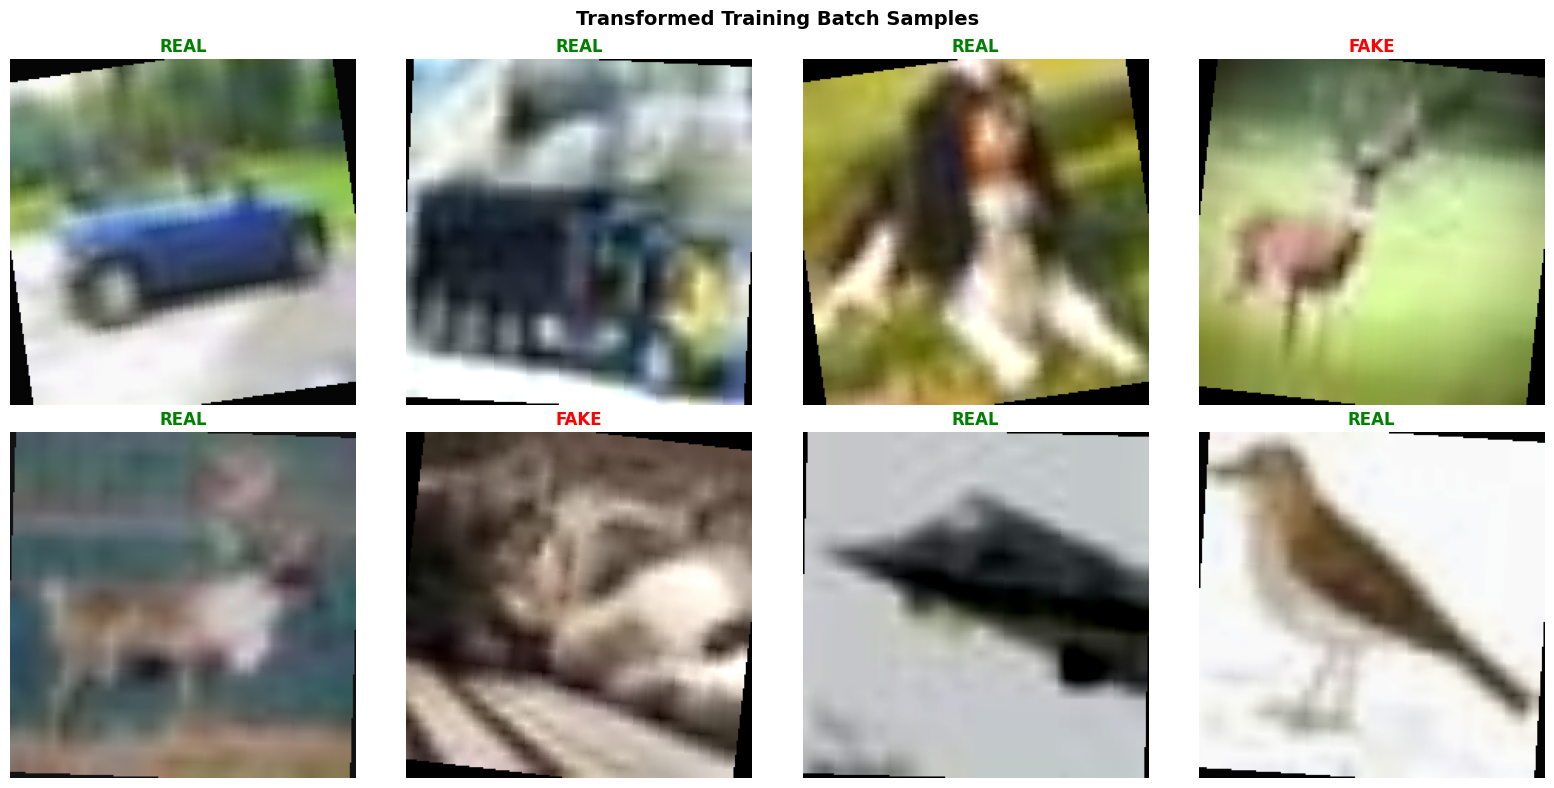


PHASE 1 COMPLETE!

You're now ready to proceed to Phase 2: Baseline Model Development

Summary:
  • Dataset loaded: 100,000 images
  • Training samples: 70,000
  • Validation samples: 15,000
  • Test samples: 15,000
  • DataLoaders created and tested ✓


In [10]:
# Test DataLoader
print("\n" + "="*50)
print("TESTING DATALOADER")
print("="*50)

# Get one batch
images_batch, labels_batch = next(iter(train_loader))
print(f"\n✓ Successfully loaded batch:")
print(f"   Batch shape: {images_batch.shape}")
print(f"   Labels shape: {labels_batch.shape}")
print(f"   Labels in batch: {labels_batch.tolist()[:10]}... (0=REAL, 1=FAKE)")

# Visualize a transformed batch
def denormalize(tensor):
    """Denormalize tensor for visualization"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i in range(8):
    img = denormalize(images_batch[i]).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    axes[i].imshow(img)
    label_text = 'REAL' if labels_batch[i] == 0 else 'FAKE'
    color = 'green' if labels_batch[i] == 0 else 'red'
    axes[i].set_title(f'{label_text}', fontsize=12, fontweight='bold', color=color)
    axes[i].axis('off')

plt.suptitle('Transformed Training Batch Samples', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("PHASE 1 COMPLETE!")
print("="*50)
print("\nYou're now ready to proceed to Phase 2: Baseline Model Development")
print("\nSummary:")
print(f"  • Dataset loaded: {len(all_images):,} images")
print(f"  • Training samples: {len(train_images):,}")
print(f"  • Validation samples: {len(val_images):,}")
print(f"  • Test samples: {len(test_images):,}")
print(f"  • DataLoaders created and tested ✓")

In [11]:
# ========================================
# PHASE 2: BASELINE MODEL TRAINING
# ========================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

In [12]:
# ========================================
# Using Data Subset
# ========================================

# Reduce dataset size
subset_ratio = 0.3  # Use 30% of data
train_subset_size = int(len(train_images) * subset_ratio)
val_subset_size = int(len(val_images) * subset_ratio)

train_images_fast = train_images[:train_subset_size]
train_labels_fast = train_labels[:train_subset_size]
val_images_fast = val_images[:val_subset_size]
val_labels_fast = val_labels[:val_subset_size]

print(f"  Original training: {len(train_images):,} → Using: {len(train_images_fast):,}")
print(f"  Original validation: {len(val_images):,} → Using: {len(val_images_fast):,}")

# Recreate datasets with subset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CIFAKEDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

  Original training: 70,000 → Using: 21,000
  Original validation: 15,000 → Using: 4,500


In [13]:
# ========================================
# Larger Batch Size
# ========================================
batch_size = 128  # Increased from 32 to 128
print(f"  Batch size: {batch_size} (larger = faster)")

train_dataset_fast = CIFAKEDataset(train_images_fast, train_labels_fast, transform=train_transform)
val_dataset_fast = CIFAKEDataset(val_images_fast, val_labels_fast, transform=val_transform)
test_dataset_fast = CIFAKEDataset(test_images, test_labels, transform=val_transform)

train_loader_fast = DataLoader(train_dataset_fast, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader_fast = DataLoader(val_dataset_fast, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader_fast = DataLoader(test_dataset_fast, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"  Training batches: {len(train_loader_fast)} (faster iteration)")

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Using device: {device}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")

  Batch size: 128 (larger = faster)
  Training batches: 165 (faster iteration)

✓ Using device: cuda
  GPU: Tesla T4


In [14]:
# ========================================
# Lighter Model
# ========================================
print("\n" + "="*60)
print("BUILDING MODEL (EFFICIENTNET-B0)")
print("="*60)

class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True, dropout=0.2):
        super(EfficientNetClassifier, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=pretrained)
        num_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)

model = EfficientNetClassifier(num_classes=2, pretrained=True, dropout=0.2)
model = model.to(device)

# Enable mixed precision for faster training
scaler = torch.cuda.amp.GradScaler()

total_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model ready with {total_params:,} parameters")

# Setup training
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6)


BUILDING MODEL (EFFICIENTNET-B0)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20.5M/20.5M [00:00<00:00, 101MB/s]


✓ Model ready with 4,010,110 parameters


/tmp/ipython-input-220378137.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [15]:
# ========================================
# Mixed Precision Training
# ========================================
print("\n⚡ Using mixed precision training (FP16) for 2x speed boost")

def train_epoch(model, dataloader, criterion, optimizer, device, scaler):
    """Train for one epoch with mixed precision"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training', leave=False)

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed precision forward pass
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Mixed precision backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.1f}%'})

    return running_loss / len(dataloader), 100 * correct / total

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(dataloader), 100 * correct / total


⚡ Using mixed precision training (FP16) for 2x speed boost



STARTING TRAINING

Training for 10 epochs (early stopping patience=3)
------------------------------------------------------------


Training:   0%|          | 0/165 [00:00<?, ?it/s]/tmp/ipython-input-4098281127.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4098281127.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch [1/10] - 124.5s
  Train: Loss=0.1805, Acc=92.68%
  Val:   Loss=0.1563, Acc=94.58%
  ✓ Best model saved! (Val Acc: 94.58%)
------------------------------------------------------------



Epoch [2/10] - 99.3s
  Train: Loss=0.1094, Acc=95.93%
  Val:   Loss=0.1170, Acc=95.51%
  ✓ Best model saved! (Val Acc: 95.51%)
------------------------------------------------------------



Epoch [3/10] - 96.7s
  Train: Loss=0.0851, Acc=96.93%
  Val:   Loss=0.0864, Acc=96.73%
  ✓ Best model saved! (Val Acc: 96.73%)
------------------------------------------------------------



Epoch [4/10] - 101.9s
  Train: Loss=0.0703, Acc=97.49%
  Val:   Loss=0.1086, Acc=95.91%
------------------------------------------------------------



Epoch [5/10] - 101.9s
  Train: Loss=0.0624, Acc=97.62%
  Val:   Loss=0.0937, Acc=96.78%
  ✓ Best model saved! (Val Acc: 96.78%)
------------------------------------------------------------



Epoch [6/10] - 101.6s
  Train: Loss=0.0552, Acc=97.90%
  Val:   Loss=0.0787, Acc=96.96%
  ✓ Best model saved! (Val Acc: 96.96%)
------------------------------------------------------------



Epoch [7/10] - 102.2s
  Train: Loss=0.0484, Acc=98.29%
  Val:   Loss=0.0978, Acc=96.80%
------------------------------------------------------------



Epoch [8/10] - 102.1s
  Train: Loss=0.0675, Acc=97.44%
  Val:   Loss=0.0971, Acc=96.91%
------------------------------------------------------------



Epoch [9/10] - 99.3s
  Train: Loss=0.0430, Acc=98.48%
  Val:   Loss=0.0935, Acc=96.98%
  ✓ Best model saved! (Val Acc: 96.98%)
------------------------------------------------------------



Epoch [10/10] - 101.6s
  Train: Loss=0.0313, Acc=98.81%
  Val:   Loss=0.0747, Acc=97.76%
  ✓ Best model saved! (Val Acc: 97.76%)
------------------------------------------------------------

TRAINING COMPLETE! ⚡
Time: 17.20 minutes
Best Val Acc: 97.76%


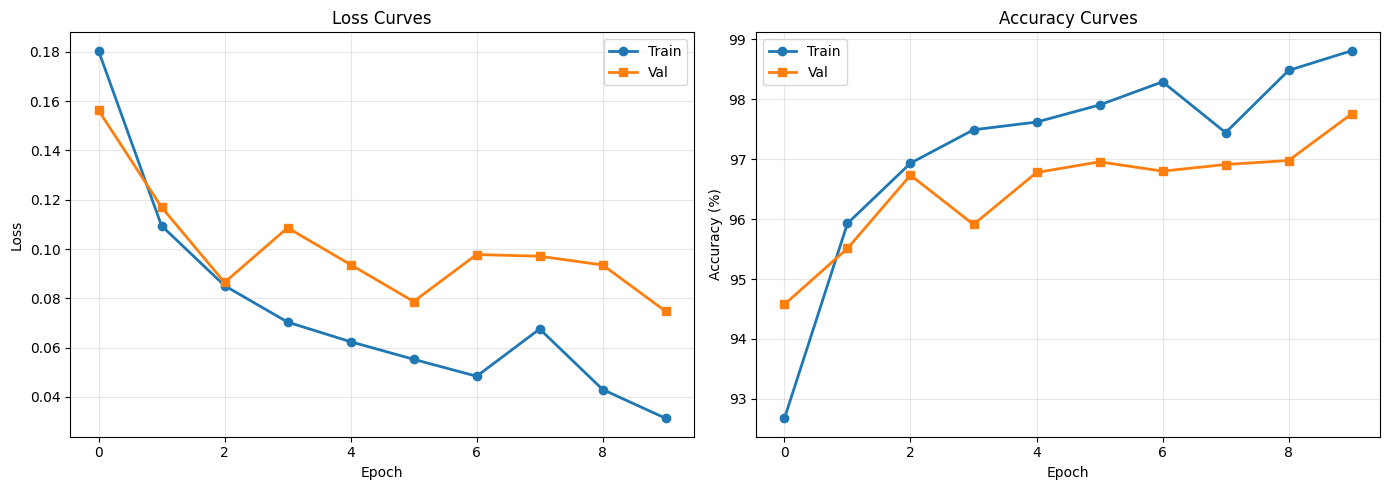


TEST RESULTS
Test Accuracy: 97.71%
Test Loss: 0.0821


In [16]:
# ========================================
# TRAINING LOOP - REDUCED EPOCHS
# ========================================
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

num_epochs = 10
best_val_acc = 0.0
patience = 3
patience_counter = 0

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

start_time = time.time()
print(f"\nTraining for {num_epochs} epochs (early stopping patience={patience})")
print("-" * 60)

for epoch in range(num_epochs):
    epoch_start = time.time()

    train_loss, train_acc = train_epoch(model, train_loader_fast, criterion, optimizer, device, scaler)
    val_loss, val_acc = validate(model, val_loader_fast, criterion, device)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    epoch_time = time.time() - epoch_start

    print(f"\nEpoch [{epoch+1}/{num_epochs}] - {epoch_time:.1f}s")
    print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
    print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc
        }, 'best_efficientnet_cifake_fast.pth')
        print(f"  ✓ Best model saved! (Val Acc: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⚠ Early stopping at epoch {epoch+1}")
            break

    print("-" * 60)

total_time = time.time() - start_time
print(f"\n{'='*60}")
print(f"TRAINING COMPLETE! ⚡")
print(f"{'='*60}")
print(f"Time: {total_time/60:.2f} minutes")
print(f"Best Val Acc: {best_val_acc:.2f}%")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history['train_loss'], 'o-', label='Train', linewidth=2)
ax1.plot(history['val_loss'], 's-', label='Val', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history['train_acc'], 'o-', label='Train', linewidth=2)
ax2.plot(history['val_acc'], 's-', label='Val', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_fast.png', dpi=150)
plt.show()

# Test evaluation
checkpoint = torch.load('best_efficientnet_cifake_fast.pth')
model.load_state_dict(checkpoint['model_state_dict'])
test_loss, test_acc = validate(model, test_loader_fast, criterion, device)

print(f"\n{'='*60}")
print(f"TEST RESULTS")
print(f"{'='*60}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print(f"{'='*60}")

In [17]:
# ========================================
# PHASE 3: COMPREHENSIVE MODEL EVALUATION
# ========================================

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score
)
from tqdm import tqdm
import pandas as pd

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

In [18]:
# ========================================
# LOAD BEST MODEL
# ========================================
print("\n" + "="*70)
print("LOADING BEST MODEL")
print("="*70)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model architecture (same as Phase 2)
from torchvision import models

class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True, dropout=0.2):
        super(EfficientNetClassifier, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=pretrained)
        num_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)

# Initialize and load weights
model = EfficientNetClassifier(num_classes=2, pretrained=False)
checkpoint = torch.load('best_efficientnet_cifake_fast.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"✓ Model loaded successfully")
print(f"  Best validation accuracy from training: {checkpoint['val_acc']:.2f}%")


LOADING BEST MODEL


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✓ Model loaded successfully
  Best validation accuracy from training: 97.76%


In [19]:
# ========================================
# COLLECT PREDICTIONS
# ========================================
print("\n" + "="*70)
print("COLLECTING MODEL PREDICTIONS ON TEST SET")
print("="*70)

def collect_predictions(model, dataloader, device):
    """Collect all predictions, labels, and probabilities"""
    model.eval()

    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)

            # Get model outputs
            with torch.cuda.amp.autocast():
                outputs = model(images)

            # Get probabilities using softmax
            probs = torch.softmax(outputs, dim=1)

            # Get predicted classes
            _, predictions = torch.max(outputs, 1)

            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probabilities.extend(probs.cpu().numpy())

    return (
        np.array(all_labels),
        np.array(all_predictions),
        np.array(all_probabilities)
    )

# Collect predictions
true_labels, predictions, probabilities = collect_predictions(
    model, test_loader_fast, device
)

print(f"\n Collected predictions for {len(true_labels):,} test samples")
print(f"  Class distribution:")
print(f"    REAL (0): {np.sum(true_labels == 0):,} samples")
print(f"    FAKE (1): {np.sum(true_labels == 1):,} samples")


COLLECTING MODEL PREDICTIONS ON TEST SET


Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]/tmp/ipython-input-2415154326.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 118/118 [00:32<00:00,  3.59it/s]


 Collected predictions for 15,000 test samples
  Class distribution:
    REAL (0): 7,500 samples
    FAKE (1): 7,500 samples


In [20]:
# ========================================
# CLASSIFICATION REPORT
# ========================================
class_names = ['REAL', 'FAKE']

# Generate classification report
report = classification_report(
    true_labels,
    predictions,
    target_names=class_names,
    digits=4
)

print("\n" + report)

# Calculate additional metrics
accuracy = np.mean(predictions == true_labels) * 100
precision = precision_score(true_labels, predictions, average='weighted') * 100
recall = recall_score(true_labels, predictions, average='weighted') * 100
f1 = f1_score(true_labels, predictions, average='weighted') * 100

print(f"\nAGGREGATE METRICS:")
print(f"  Overall Accuracy:  {accuracy:.2f}%")
print(f"  Weighted Precision: {precision:.2f}%")
print(f"  Weighted Recall:    {recall:.2f}%")
print(f"  Weighted F1-Score:  {f1:.2f}%")


              precision    recall  f1-score   support

        REAL     0.9766    0.9776    0.9771      7500
        FAKE     0.9776    0.9765    0.9771      7500

    accuracy                         0.9771     15000
   macro avg     0.9771    0.9771    0.9771     15000
weighted avg     0.9771    0.9771    0.9771     15000


AGGREGATE METRICS:
  Overall Accuracy:  97.71%
  Weighted Precision: 97.71%
  Weighted Recall:    97.71%
  Weighted F1-Score:  97.71%



CONFUSION MATRIX ANALYSIS

Confusion Matrix (Counts):
                Predicted REAL  Predicted FAKE
Actual REAL              7,332             168
Actual FAKE                176           7,324

Confusion Matrix (Percentages):
                Predicted REAL  Predicted FAKE
Actual REAL             97.76%           2.24%
Actual FAKE              2.35%          97.65%


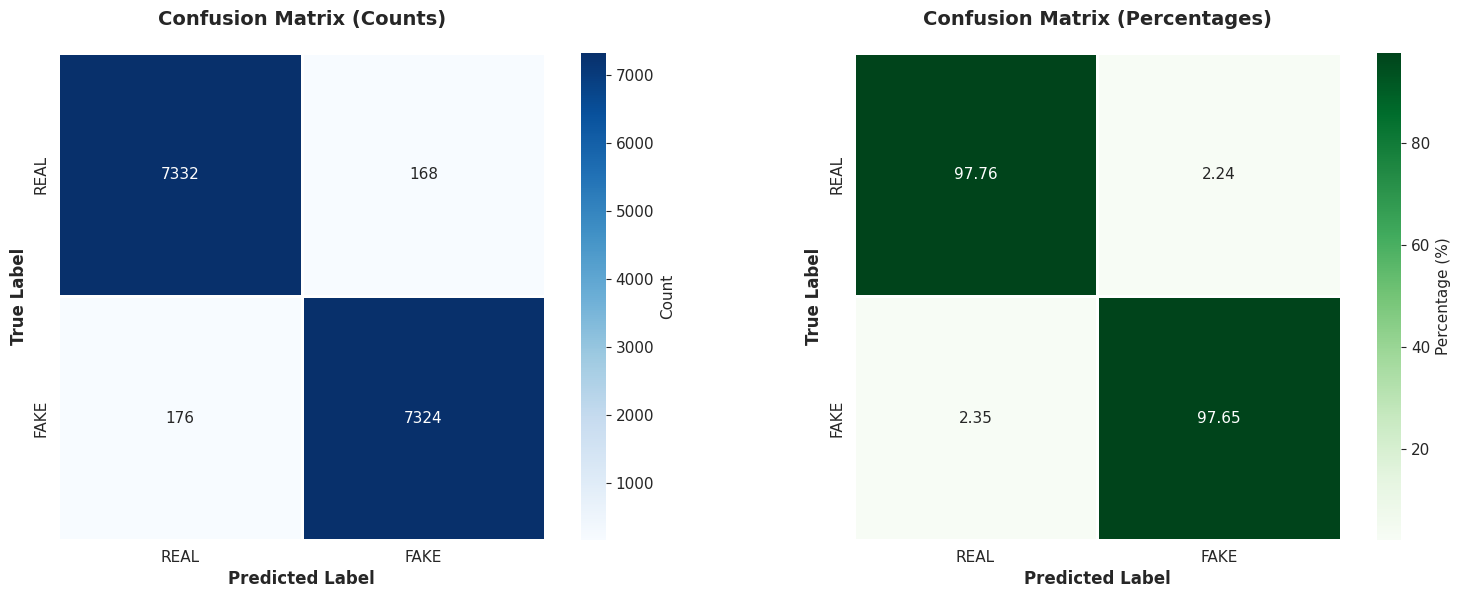


 Confusion matrix saved as 'confusion_matrix.png'


In [21]:
# ========================================
# CONFUSION MATRIX
# ========================================
print("\n" + "="*70)
print("CONFUSION MATRIX ANALYSIS")
print("="*70)

cm = confusion_matrix(true_labels, predictions)

# Calculate percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

print("\nConfusion Matrix (Counts):")
print(f"                Predicted REAL  Predicted FAKE")
print(f"Actual REAL     {cm[0,0]:>14,}  {cm[0,1]:>14,}")
print(f"Actual FAKE     {cm[1,0]:>14,}  {cm[1,1]:>14,}")

print("\nConfusion Matrix (Percentages):")
print(f"                Predicted REAL  Predicted FAKE")
print(f"Actual REAL     {cm_percent[0,0]:>13.2f}%  {cm_percent[0,1]:>13.2f}%")
print(f"Actual FAKE     {cm_percent[1,0]:>13.2f}%  {cm_percent[1,1]:>13.2f}%")

# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Counts
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'},
    ax=axes[0],
    square=True,
    linewidths=2,
    linecolor='white'
)
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Plot 2: Percentages
sns.heatmap(
    cm_percent,
    annot=True,
    fmt='.2f',
    cmap='Greens',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Percentage (%)'},
    ax=axes[1],
    square=True,
    linewidths=2,
    linecolor='white'
)
axes[1].set_title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold', pad=20)
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Confusion matrix saved as 'confusion_matrix.png'")


✓ ROC AUC Score: 0.9969
  (1.0 = Perfect classifier, 0.5 = Random guessing)


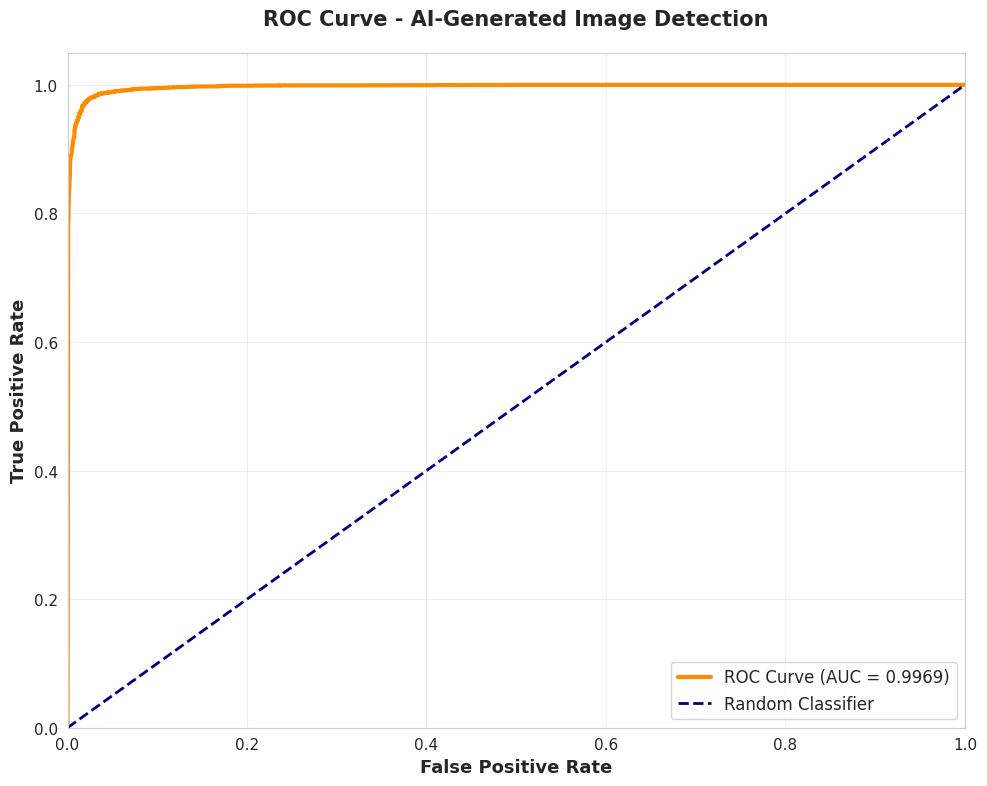

✓ ROC curve saved as 'roc_curve.png'


In [22]:
# ========================================
# ROC CURVE & AUC
# ========================================

# Calculate ROC curve for FAKE class (class 1)
fpr, tpr, thresholds = roc_curve(true_labels, probabilities[:, 1])
roc_auc = auc(fpr, tpr)

print(f"\n✓ ROC AUC Score: {roc_auc:.4f}")
print(f"  (1.0 = Perfect classifier, 0.5 = Random guessing)")

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(
    fpr, tpr,
    color='darkorange',
    lw=3,
    label=f'ROC Curve (AUC = {roc_auc:.4f})'
)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curve - AI-Generated Image Detection', fontsize=15, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ ROC curve saved as 'roc_curve.png'")


PRECISION-RECALL CURVE

✓ Average Precision Score: 0.9965


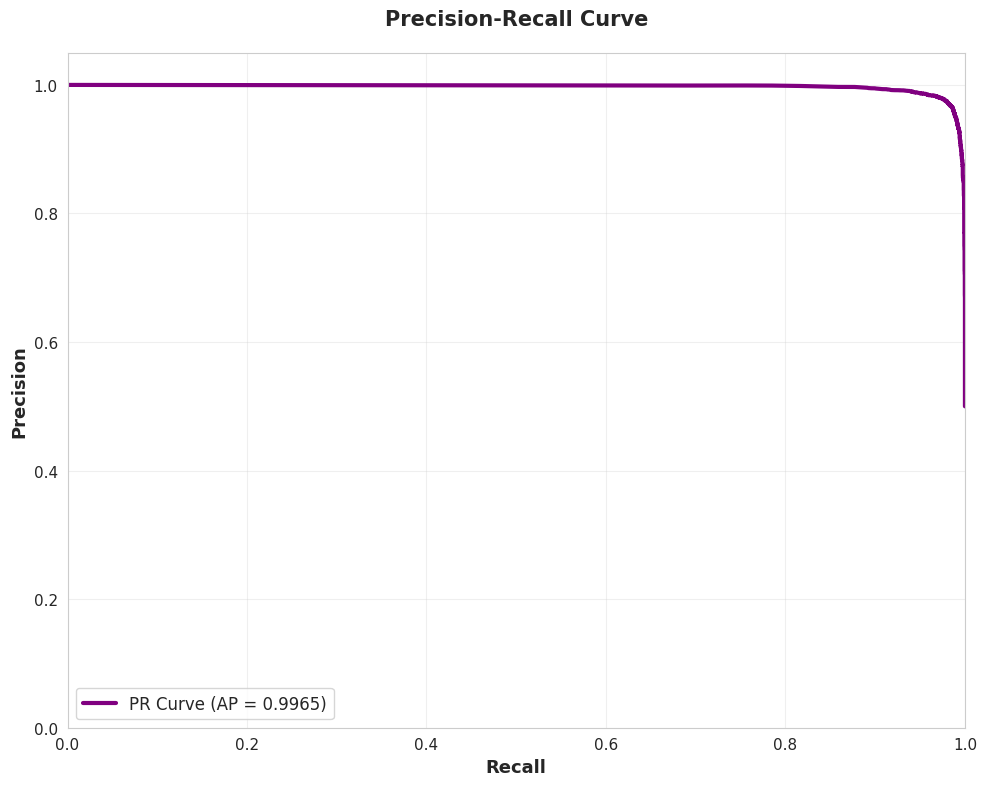

✓ Precision-Recall curve saved as 'precision_recall_curve.png'


In [23]:
# ========================================
# STEP 6: PRECISION-RECALL CURVE
# ========================================
print("\n" + "="*70)
print("PRECISION-RECALL CURVE")
print("="*70)

precision_curve, recall_curve, pr_thresholds = precision_recall_curve(
    true_labels, probabilities[:, 1]
)

# Calculate average precision
from sklearn.metrics import average_precision_score
avg_precision = average_precision_score(true_labels, probabilities[:, 1])

print(f"\n✓ Average Precision Score: {avg_precision:.4f}")

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
plt.plot(
    recall_curve, precision_curve,
    color='purple',
    lw=3,
    label=f'PR Curve (AP = {avg_precision:.4f})'
)
plt.xlabel('Recall', fontsize=13, fontweight='bold')
plt.ylabel('Precision', fontsize=13, fontweight='bold')
plt.title('Precision-Recall Curve', fontsize=15, fontweight='bold', pad=20)
plt.legend(loc="lower left", fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.savefig('precision_recall_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Precision-Recall curve saved as 'precision_recall_curve.png'")


PER-CLASS PERFORMANCE BREAKDOWN

Class  Precision    Recall  F1-Score  Support
 REAL  97.655834 97.760000 97.707889     7500
 FAKE  97.757608 97.653333 97.705443     7500


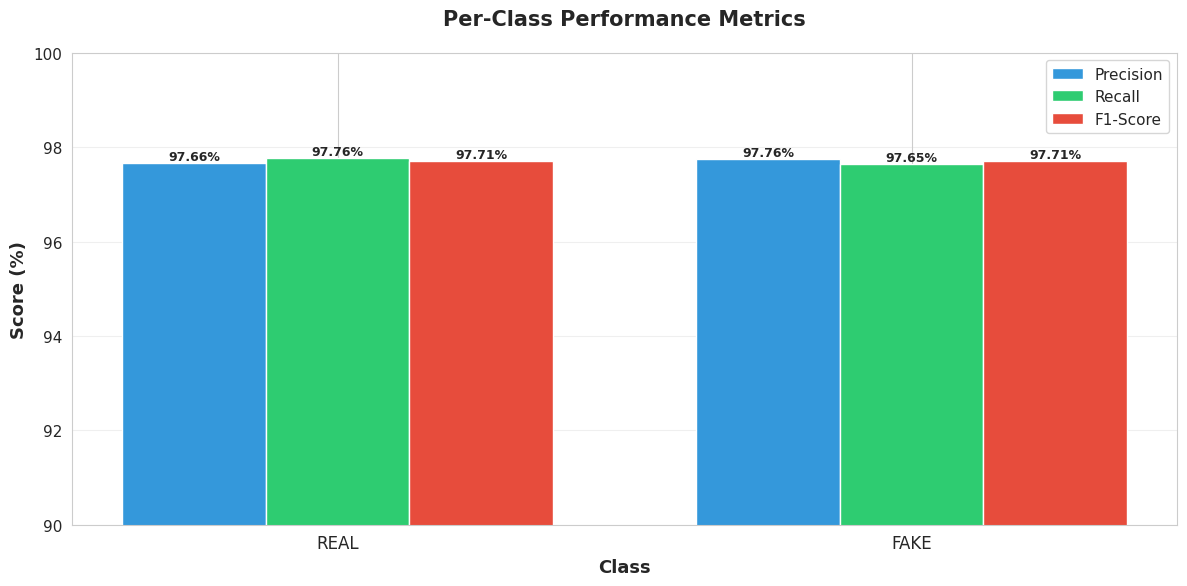


✓ Per-class metrics saved as 'per_class_metrics.png'


In [24]:
# ========================================
# STEP 7: PER-CLASS PERFORMANCE
# ========================================
print("\n" + "="*70)
print("PER-CLASS PERFORMANCE BREAKDOWN")
print("="*70)

# Calculate per-class metrics
from sklearn.metrics import precision_recall_fscore_support

precision_per_class, recall_per_class, f1_per_class, support_per_class = \
    precision_recall_fscore_support(true_labels, predictions)

# Create DataFrame
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision_per_class * 100,
    'Recall': recall_per_class * 100,
    'F1-Score': f1_per_class * 100,
    'Support': support_per_class
})

print("\n" + metrics_df.to_string(index=False))

# Visualize per-class metrics
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(class_names))
width = 0.25

bars1 = ax.bar(x - width, metrics_df['Precision'], width, label='Precision', color='#3498db')
bars2 = ax.bar(x, metrics_df['Recall'], width, label='Recall', color='#2ecc71')
bars3 = ax.bar(x + width, metrics_df['F1-Score'], width, label='F1-Score', color='#e74c3c')

ax.set_xlabel('Class', fontsize=13, fontweight='bold')
ax.set_ylabel('Score (%)', fontsize=13, fontweight='bold')
ax.set_title('Per-Class Performance Metrics', fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(class_names, fontsize=12)
ax.legend(fontsize=11)
ax.set_ylim([90, 100])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold'
        )

plt.tight_layout()
plt.savefig('per_class_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Per-class metrics saved as 'per_class_metrics.png'")


ERROR ANALYSIS - MISCLASSIFIED SAMPLES

✓ Total misclassified: 344 out of 15000 (2.29%)

Error Breakdown:
  False Positives (REAL → FAKE): 168 (48.8% of errors)
  False Negatives (FAKE → REAL): 176 (51.2% of errors)


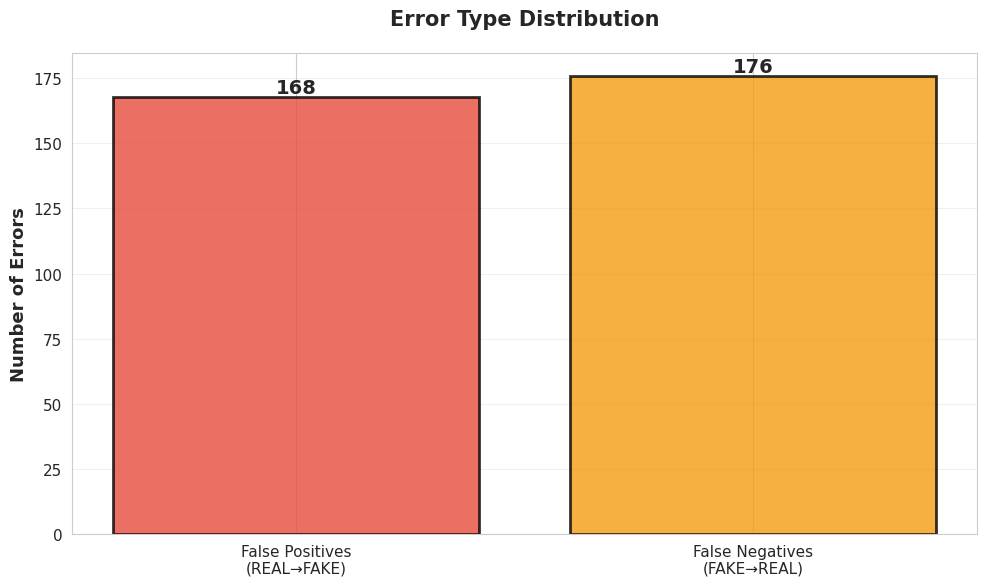


✓ Error distribution saved as 'error_distribution.png'


In [25]:
# ========================================
# STEP 8: ERROR ANALYSIS
# ========================================
print("\n" + "="*70)
print("ERROR ANALYSIS - MISCLASSIFIED SAMPLES")
print("="*70)

# Find misclassified samples
misclassified_indices = np.where(predictions != true_labels)[0]
num_errors = len(misclassified_indices)

print(f"\n✓ Total misclassified: {num_errors} out of {len(true_labels)} ({num_errors/len(true_labels)*100:.2f}%)")

# Analyze error types
false_positives = np.sum((predictions == 1) & (true_labels == 0))  # Predicted FAKE, actually REAL
false_negatives = np.sum((predictions == 0) & (true_labels == 1))  # Predicted REAL, actually FAKE

print(f"\nError Breakdown:")
print(f"  False Positives (REAL → FAKE): {false_positives:,} ({false_positives/num_errors*100:.1f}% of errors)")
print(f"  False Negatives (FAKE → REAL): {false_negatives:,} ({false_negatives/num_errors*100:.1f}% of errors)")

# Visualize error distribution
fig, ax = plt.subplots(figsize=(10, 6))
error_types = ['False Positives\n(REAL→FAKE)', 'False Negatives\n(FAKE→REAL)']
error_counts = [false_positives, false_negatives]
colors = ['#e74c3c', '#f39c12']

bars = ax.bar(error_types, error_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., height,
        f'{int(height)}',
        ha='center', va='bottom', fontsize=14, fontweight='bold'
    )

ax.set_ylabel('Number of Errors', fontsize=13, fontweight='bold')
ax.set_title('Error Type Distribution', fontsize=15, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('error_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Error distribution saved as 'error_distribution.png'")


PREDICTION CONFIDENCE ANALYSIS

Confidence Statistics:
  Correct Predictions:
    Mean confidence: 99.12%
    Median confidence: 100.00%
    Std deviation: inf%

  Incorrect Predictions:
    Mean confidence: 84.81%
    Median confidence: 91.12%
    Std deviation: inf%


/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:164: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/tmp/ipython-input-366868568.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[1].boxplot(


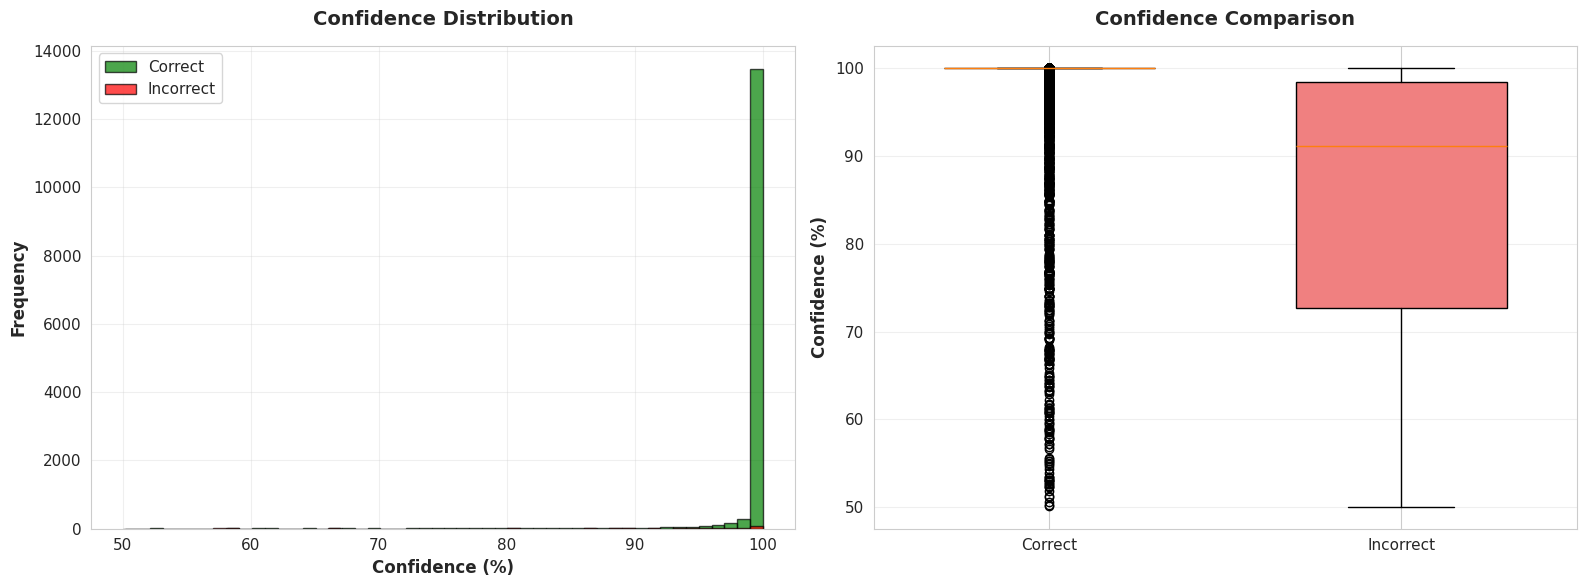


✓ Confidence analysis saved as 'confidence_analysis.png'


In [26]:
# ========================================
# STEP 9: CONFIDENCE ANALYSIS
# ========================================
print("\n" + "="*70)
print("PREDICTION CONFIDENCE ANALYSIS")
print("="*70)

# Get confidence scores (max probability for each prediction)
confidence_scores = np.max(probabilities, axis=1) * 100

# Separate by correct/incorrect predictions
correct_mask = predictions == true_labels
correct_confidence = confidence_scores[correct_mask]
incorrect_confidence = confidence_scores[~correct_mask]

print(f"\nConfidence Statistics:")
print(f"  Correct Predictions:")
print(f"    Mean confidence: {np.mean(correct_confidence):.2f}%")
print(f"    Median confidence: {np.median(correct_confidence):.2f}%")
print(f"    Std deviation: {np.std(correct_confidence):.2f}%")

print(f"\n  Incorrect Predictions:")
print(f"    Mean confidence: {np.mean(incorrect_confidence):.2f}%")
print(f"    Median confidence: {np.median(incorrect_confidence):.2f}%")
print(f"    Std deviation: {np.std(incorrect_confidence):.2f}%")

# Plot confidence distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(correct_confidence, bins=50, alpha=0.7, label='Correct', color='green', edgecolor='black')
axes[0].hist(incorrect_confidence, bins=50, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
axes[0].set_xlabel('Confidence (%)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Confidence Distribution', fontsize=14, fontweight='bold', pad=15)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Box plot
data_to_plot = [correct_confidence, incorrect_confidence]
box = axes[1].boxplot(
    data_to_plot,
    labels=['Correct', 'Incorrect'],
    patch_artist=True,
    widths=0.6
)
box['boxes'][0].set_facecolor('lightgreen')
box['boxes'][1].set_facecolor('lightcoral')

axes[1].set_ylabel('Confidence (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Confidence Comparison', fontsize=14, fontweight='bold', pad=15)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('confidence_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Confidence analysis saved as 'confidence_analysis.png'")

In [29]:
# ========================================
# STEP 10: SUMMARY REPORT
# ========================================
print("\n" + "="*70)
print("COMPREHENSIVE EVALUATION SUMMARY")
print("="*70)

summary_report = f"""
╔══════════════════════════════════════════════════════════════════════╗
║           CIFAKE IMAGE CLASSIFICATION - EVALUATION REPORT            ║
╚══════════════════════════════════════════════════════════════════════╝

MODEL INFORMATION:
  Architecture: EfficientNet-B0
  Dataset: CIFAKE (Real vs AI-Generated Images)
  Test Samples: {len(true_labels):,}

OVERALL PERFORMANCE:
  Test Accuracy:        {accuracy:.2f}%
  Weighted Precision:   {precision:.2f}%
  Weighted Recall:      {recall:.2f}%
  Weighted F1-Score:    {f1:.2f}%
  ROC AUC Score:        {roc_auc:.4f}
  Average Precision:    {avg_precision:.4f}

PER-CLASS METRICS:
  REAL Images:
    Precision: {precision_per_class[0]*100:.2f}%
    Recall:    {recall_per_class[0]*100:.2f}%
    F1-Score:  {f1_per_class[0]*100:.2f}%

  FAKE (AI-Generated) Images:
    Precision: {precision_per_class[1]*100:.2f}%
    Recall:    {recall_per_class[1]*100:.2f}%
    F1-Score:  {f1_per_class[1]*100:.2f}%

ERROR ANALYSIS:
  Total Errors:         {num_errors} ({num_errors/len(true_labels)*100:.2f}%)
  False Positives:      {false_positives} (REAL classified as FAKE)
  False Negatives:      {false_negatives} (FAKE classified as REAL)

CONFIDENCE ANALYSIS:
  Correct Predictions:  {np.mean(correct_confidence):.2f}% (avg confidence)
  Incorrect Predictions: {np.mean(incorrect_confidence):.2f}% (avg confidence)

FILES GENERATED:
  ✓ confusion_matrix.png
  ✓ roc_curve.png
  ✓ precision_recall_curve.png
  ✓ per_class_metrics.png
  ✓ error_distribution.png
  ✓ confidence_analysis.png
  ✓ evaluation_summary.txt

{'='*70}
"""

print(summary_report)

# Save summary to file
with open('evaluation_summary.txt', 'w') as f:
    f.write(summary_report)

print("\n✓ Summary report saved as 'evaluation_summary.txt'")

print("\n" + "="*70)
print("PHASE 3 COMPLETE!")
print("="*70)


COMPREHENSIVE EVALUATION SUMMARY

╔══════════════════════════════════════════════════════════════════════╗
║           CIFAKE IMAGE CLASSIFICATION - EVALUATION REPORT            ║
╚══════════════════════════════════════════════════════════════════════╝

MODEL INFORMATION:
  Architecture: EfficientNet-B0
  Dataset: CIFAKE (Real vs AI-Generated Images)
  Test Samples: 15,000
  
OVERALL PERFORMANCE:
  Test Accuracy:        97.71%
  Weighted Precision:   97.71%
  Weighted Recall:      97.71%
  Weighted F1-Score:    97.71%
  ROC AUC Score:        0.9969
  Average Precision:    0.9965

PER-CLASS METRICS:
  REAL Images:
    Precision: 97.66%
    Recall:    97.76%
    F1-Score:  97.71%
    
  FAKE (AI-Generated) Images:
    Precision: 97.76%
    Recall:    97.65%
    F1-Score:  97.71%

ERROR ANALYSIS:
  Total Errors:         344 (2.29%)
  False Positives:      168 (REAL classified as FAKE)
  False Negatives:      176 (FAKE classified as REAL)

CONFIDENCE ANALYSIS:
  Correct Predictions:  99.1